# BBC News Classification (TF)

We will implement a news classification based on [BBC News Classification Dataset](https://www.kaggle.com/c/learn-ai-bbc/overview), which contains 2225 examples of news articles with their respective labels. 

In [1]:
import os
import io
import csv
import pandas as pd
import tensorflow as tf
import numpy as np
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

In [2]:
TRAIN_PATH = os.path.join("../datasets/bbc-news", "BBC News Train.csv")
TEST_PATH = os.path.join("../datasets/bbc-news", "BBC News Test.csv")

In [3]:
df = pd.read_csv(TRAIN_PATH)
df.head()

,ArticleId,Text,Category
0,1833,worldcom ex-boss launches defence lawyers defe...,business
1,154,german business confidence slides german busin...,business
2,1101,bbc poll indicates economic gloom citizens in ...,business
3,1976,lifestyle governs mobile choice faster bett...,tech
4,917,enron bosses in $168m payout eighteen former e...,business


Text(0, 0.5, 'Examples')

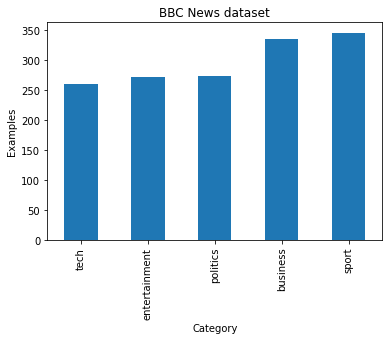

In [4]:
df.Category.value_counts().sort_values().plot(kind = 'bar')
plt.title("BBC News dataset")
plt.xlabel("Category")
plt.ylabel("Examples")

## Defining useful global variables

- `NUM_WORDS`: The maximum number of words to keep, based on word frequency. Defaults to 1000.


- `EMBEDDING_DIM`: Dimension of the dense embedding, will be used in the embedding layer of the model. Defaults to 16.


- `MAXLEN`: Maximum length of all sequences. Defaults to 120.


- `PADDING`: Padding strategy (pad either before or after each sequence.). Defaults to 'post'.


- `OOV_TOKEN`: Token to replace out-of-vocabulary words during text_to_sequence calls. Defaults to "\<OOV>".

    
- `TRAINING_SPLIT`: Proportion of data used for training. Defaults to 0.8

In [5]:
NUM_WORDS = 1000
EMBEDDING_DIM = 32
MAXLEN = 120
PADDING = 'post'
OOV_TOKEN = "<OOV>"
TRAINING_SPLIT = .8

## Loading and pre-processing the data

Remove stopwords from text and to load the data from a csv file.

In [6]:
def remove_stopwords(sentence):
    """
    Removes a list of stopwords
    
    Args:
        sentence (string): sentence to remove the stopwords from
    
    Returns:
        sentence (string): lowercase sentence without the stopwords
    """
    # List of stopwords
    stopwords = ["a", "about", "above", "after", "again", "against", "all", "am", "an", "and", "any", "are", "as", "at", "be", "because", "been", "before", "being", "below", "between", "both", "but", "by", "could", "did", "do", "does", "doing", "down", "during", "each", "few", "for", "from", "further", "had", "has", "have", "having", "he", "he'd", "he'll", "he's", "her", "here", "here's", "hers", "herself", "him", "himself", "his", "how", "how's", "i", "i'd", "i'll", "i'm", "i've", "if", "in", "into", "is", "it", "it's", "its", "itself", "let's", "me", "more", "most", "my", "myself", "nor", "of", "on", "once", "only", "or", "other", "ought", "our", "ours", "ourselves", "out", "over", "own", "same", "she", "she'd", "she'll", "she's", "should", "so", "some", "such", "than", "that", "that's", "the", "their", "theirs", "them", "themselves", "then", "there", "there's", "these", "they", "they'd", "they'll", "they're", "they've", "this", "those", "through", "to", "too", "under", "until", "up", "very", "was", "we", "we'd", "we'll", "we're", "we've", "were", "what", "what's", "when", "when's", "where", "where's", "which", "while", "who", "who's", "whom", "why", "why's", "with", "would", "you", "you'd", "you'll", "you're", "you've", "your", "yours", "yourself", "yourselves" ]
    
    # Sentence converted to lowercase-only
    sentence = sentence.lower()

    words = sentence.split()
    no_words = [w for w in words if w not in stopwords]
    sentence = " ".join(no_words)

    return sentence

In [7]:
df['Text'] = df['Text'].map(lambda sentence: remove_stopwords(sentence))

## Training - Validation Split

In [8]:
train_sentences, val_sentences, train_labels, val_labels = \
    train_test_split(df['Text'], df['Category'], test_size=1 - TRAINING_SPLIT, random_state=1)

## Tokenization - Sequences and padding

In [9]:
def fit_tokenizer(train_sentences, num_words, oov_token):
    
    tokenizer = Tokenizer(num_words=num_words, oov_token=oov_token)
    tokenizer.fit_on_texts(train_sentences)
    
    return tokenizer

In [10]:
tokenizer = fit_tokenizer(train_sentences, NUM_WORDS, OOV_TOKEN)
word_index = tokenizer.word_index

print(f"Vocabulary contains {len(word_index)} words\n")

Vocabulary contains 22651 words



In [11]:
def seq_and_pad(sentences, tokenizer, padding, maxlen):

    sequences = tokenizer.texts_to_sequences(sentences)
    padded_sequences = pad_sequences(sequences, maxlen=maxlen, padding=padding)
    
    return padded_sequences

In [12]:
train_padded_seq = seq_and_pad(train_sentences, tokenizer, PADDING, MAXLEN)
val_padded_seq = seq_and_pad(val_sentences, tokenizer, PADDING, MAXLEN)

In [74]:
def tokenize_labels(label_tokenizer, split_labels):
    """
    Tokenizes the labels
    
    Args:
        all_labels (list of string): labels to generate the word-index from
        split_labels (list of string): labels to tokenize
    
    Returns:
        label_seq_np (array of int): tokenized labels
    """
    
    # Convert labels to sequences
    label_seq = label_tokenizer.texts_to_sequences(split_labels)
    
    # Convert sequences to a numpy array.
    label_seq_np = np.array(label_seq) - 1
    
    return label_seq_np

In [76]:
label_tokenizer = Tokenizer()
# Fit the tokenizer on all the labels
label_tokenizer.fit_on_texts(df['Category'])  
   

train_label_seq = tokenize_labels(label_tokenizer, train_labels)
val_label_seq = tokenize_labels(label_tokenizer, val_labels)

## Training the model for text classification


In [68]:
def create_model(num_words, embedding_dim, maxlen):
    
    tf.random.set_seed(123)
       
    model = tf.keras.Sequential([ 
        tf.keras.layers.Embedding(num_words, embedding_dim, input_length=maxlen),
        tf.keras.layers.Dropout(0.3),
        tf.keras.layers.GlobalAveragePooling1D(),
        tf.keras.layers.Dropout(0.3),                 
        tf.keras.layers.Dense(24, activation='relu'),
        tf.keras.layers.Dropout(0.3), 
        tf.keras.layers.Dense(5, activation='softmax')
    ])
    
    model.compile(loss='sparse_categorical_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy']) 

    return model

In [59]:
model = create_model(NUM_WORDS, EMBEDDING_DIM, MAXLEN)
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 120, 32)           32000     
                                                                 
 dropout_3 (Dropout)         (None, 120, 32)           0         
                                                                 
 global_average_pooling1d_1   (None, 32)               0         
 (GlobalAveragePooling1D)                                        
                                                                 
 dropout_4 (Dropout)         (None, 32)                0         
                                                                 
 dense_2 (Dense)             (None, 24)                792       
                                                                 
 dropout_5 (Dropout)         (None, 24)                0         
                                                      

In [60]:
history = model.fit(train_padded_seq, train_label_seq, epochs=100, validation_data=(val_padded_seq, val_label_seq))

Epoch 1/100
38/38 [==============================] - 0s 4ms/step - loss: 1.6032 - accuracy: 0.2651 - val_loss: 1.5969 - val_accuracy: 0.3087
Epoch 2/100
38/38 [==============================] - 0s 2ms/step - loss: 1.5829 - accuracy: 0.3607 - val_loss: 1.5704 - val_accuracy: 0.4228
Epoch 3/100
38/38 [==============================] - 0s 2ms/step - loss: 1.5403 - accuracy: 0.4396 - val_loss: 1.5210 - val_accuracy: 0.4497
Epoch 4/100
38/38 [==============================] - 0s 2ms/step - loss: 1.4703 - accuracy: 0.4958 - val_loss: 1.4304 - val_accuracy: 0.5067
Epoch 5/100
38/38 [==============================] - 0s 3ms/step - loss: 1.3509 - accuracy: 0.5747 - val_loss: 1.2994 - val_accuracy: 0.5638
Epoch 6/100
38/38 [==============================] - 0s 3ms/step - loss: 1.2115 - accuracy: 0.6275 - val_loss: 1.1447 - val_accuracy: 0.6275
Epoch 7/100
38/38 [==============================] - 0s 3ms/step - loss: 1.0531 - accuracy: 0.6837 - val_loss: 0.9929 - val_accuracy: 0.7282
Epoch 8/100
3

Epoch 59/100
38/38 [==============================] - 0s 2ms/step - loss: 0.0333 - accuracy: 0.9966 - val_loss: 0.2059 - val_accuracy: 0.9430
Epoch 60/100
38/38 [==============================] - 0s 2ms/step - loss: 0.0339 - accuracy: 0.9916 - val_loss: 0.2100 - val_accuracy: 0.9396
Epoch 61/100
38/38 [==============================] - 0s 2ms/step - loss: 0.0350 - accuracy: 0.9933 - val_loss: 0.2076 - val_accuracy: 0.9396
Epoch 62/100
38/38 [==============================] - 0s 2ms/step - loss: 0.0332 - accuracy: 0.9950 - val_loss: 0.2083 - val_accuracy: 0.9430
Epoch 63/100
38/38 [==============================] - 0s 2ms/step - loss: 0.0330 - accuracy: 0.9941 - val_loss: 0.2116 - val_accuracy: 0.9396
Epoch 64/100
38/38 [==============================] - 0s 2ms/step - loss: 0.0305 - accuracy: 0.9933 - val_loss: 0.2105 - val_accuracy: 0.9430
Epoch 65/100
38/38 [==============================] - 0s 2ms/step - loss: 0.0256 - accuracy: 0.9966 - val_loss: 0.2136 - val_accuracy: 0.9430
Epoch 

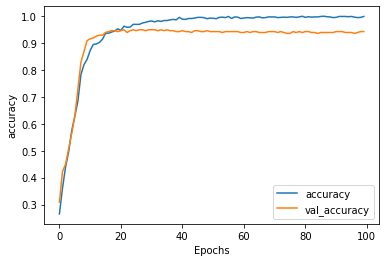

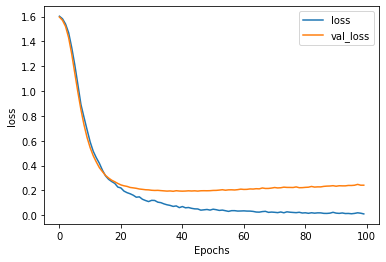

In [61]:
def plot_graphs(history, metric):
    plt.plot(history.history[metric])
    plt.plot(history.history[f'val_{metric}'])
    plt.xlabel("Epochs")
    plt.ylabel(metric)
    plt.legend([metric, f'val_{metric}'])
    plt.show()
    
plot_graphs(history, "accuracy")
plot_graphs(history, "loss")

### Model Evaluation

In [62]:
preds = model.predict(val_padded_seq)
indices, values = tf.nn.top_k(preds, k=1)

10/10 [==============================] - 0s 759us/step


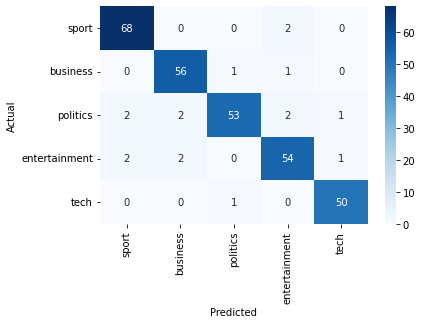

In [90]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

labels = label_tokenizer.word_index.keys()
conf_mat = confusion_matrix(val_label_seq, values)
sns.heatmap(conf_mat, annot=True, fmt='d',
                       xticklabels=labels, yticklabels=labels, cmap='Blues')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()